# Imports

The deep learning environment and the quantum environment

In [8]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import qutip as qt
from collections import defaultdict

import torch
from tensordict.nn import TensorDictModule
from tensordict.tensordict import TensorDict, TensorDictBase
from torch import nn

import qcontrol
device = qcontrol.device
print("Using device", device)

# Set seed for repeatability
env = qcontrol.QuantumEnv()
torch.manual_seed(0)
env.set_seed(0);

Using device cuda:0


## Define the Problem

Here we specify the system parameters and the initial and final states for the control problem

In [9]:
# Integration timestep
dt = 0.01

# Desired length of pulse
gate_time = 30

# Tunable penalty for large control inputs
control_penalty = 15

# For the over-constrained example
# control_penalty = 200

# For the under-constrained example
# control_penalty = 0.1

# Avg fidelity between starting and 
# ending states to be considered done
close_thresh = 0.99999

np_ctype = np.complex64

# Starting States on the Columns
psi_0 = np.array([[1,  0],
                  [0,  1]]).astype(np_ctype)

# Desired Final States on the Columns
psi_f = np.array([[0,  1],
                  [1,  0]]).astype(np_ctype)

# System Hamiltonian
H0 = np.array([[1,  0],
               [0, -1]]).astype(np_ctype)
# Drive Hamiltonian
H1 = np.array([[0,  1],
               [1,  0]]).astype(np_ctype)


## Define the Network

In [10]:

class agentNet(nn.Module):

    def __init__(self):
        super(agentNet, self).__init__()
        ctype = torch.float32
        p_drop = 0.01
        bias = True
        self.net = nn.Sequential(
                    nn.Linear(2*psi_0.size + 1, 64, dtype=ctype, bias=bias),
                    nn.Tanh(),
                    nn.Linear(64, 64, dtype=ctype, bias=bias),
                    nn.Tanh(),
                    nn.Dropout(p=p_drop),
                    nn.Linear(64, 16, dtype=ctype, bias=bias),
                    nn.Tanh(),
                    nn.Dropout(p=p_drop),
                    nn.Linear(16, 1, dtype=ctype, bias=bias),
                    )

    # Takes in psi_real, psi_imag, and t_left
    def forward(self, x1, x2, x3):
        flattened = torch.hstack((x1.flatten(1, -1), x2.flatten(1, -1), x3.reshape(-1,1)))
        return self.net(flattened)

agent = agentNet().to(device)
policy = TensorDictModule(agent,
                          in_keys=["psi_real", "psi_imag", "t_left"],
                           out_keys=["action"])
policy

TensorDictModule(
    module=agentNet(
      (net): Sequential(
        (0): Linear(in_features=9, out_features=64, bias=True)
        (1): Tanh()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): Tanh()
        (4): Dropout(p=0.01, inplace=False)
        (5): Linear(in_features=64, out_features=16, bias=True)
        (6): Tanh()
        (7): Dropout(p=0.01, inplace=False)
        (8): Linear(in_features=16, out_features=1, bias=True)
      )
    ),
    device=cuda:0,
    in_keys=['psi_real', 'psi_imag', 't_left'],
    out_keys=['action'])

In [11]:
optim = torch.optim.Adam(policy.parameters(), lr=2e-3)

# Train Parameters
batch_size = 100
rollout_len = int(gate_time/dt)
total_trials = 10000//2
pbar = tqdm.tqdm(range(total_trials // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_trials)
logs = defaultdict(list)

# Keep track of the best run throughout training
logs["best_run"] = {}
logs["best_run"]["fidelity"] = 0
logs["best_run"]["reward"] = -np.inf
logs["best_run"]["control"] = None
logs["best_run"]["psi"] = None

params = env.gen_params(batch_size=[batch_size], dt=dt,
                        gate_time=gate_time,
                        control_penalty=control_penalty, psi_0=psi_0,
                        psi_f=psi_f, H0=H0, H1=H1, close_thresh=close_thresh)
for _ in pbar:

    # Initialize the runs
    init_td = env.reset(params)
    # Do a rollout or trial
    rollout = env.rollout(rollout_len, policy, tensordict=init_td, auto_reset=False)

    # Now do gradient descent iteration
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(agent.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f}, gradient norm: {gn: 4.4}"
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())

    # Check to see if any trial in this beat the best previous one
    psi_final = rollout["psi_real"][:, -1] + 1.0j*rollout["psi_imag"][:, -1]
    F_final = env.avg_fidelity(params["params","psi_f"], psi_final)
    ibest = torch.argmax(F_final)
    rbest = rollout["next", "reward"][ibest, -1]
    fbest = F_final[ibest]
    if fbest > logs["best_run"]["fidelity"]:
        logs["best_run"]["reward"] = rbest
        logs["best_run"]["psi"] = rollout["psi_real"][ibest] + 1.0j*rollout["psi_imag"][ibest]
        logs["best_run"]["control"] = rollout["action"][ibest]
        logs["best_run"]["fidelity"] = fbest

    scheduler.step()


reward: -0.1429, last reward: -0.0163, gradient norm:  0.2156: 100%|██████████| 50/50 [04:48<00:00,  5.77s/it]


# Visualize the best pulse from training

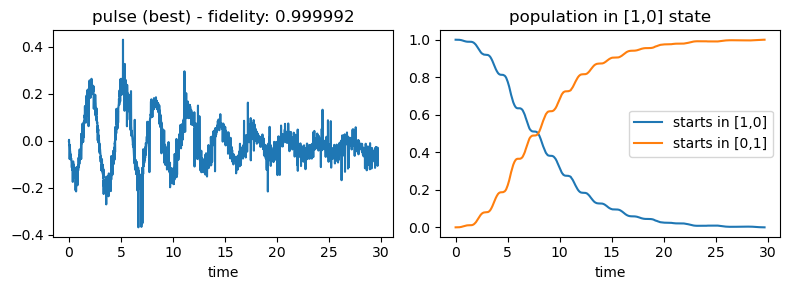

In [12]:

timesteps = rollout_len
tlist = np.arange(timesteps)*dt

pulse = logs["best_run"]["control"].cpu().detach().numpy()
psi_hist = logs["best_run"]["psi"].cpu().detach().numpy()
fid = logs["best_run"]["fidelity"].cpu().detach().numpy()
len_pulse = pulse.size

prob0_start0 = [np.abs(s[0, 0])**2 for s in psi_hist]
prob0_start1 = [np.abs(s[0, 1])**2 for s in psi_hist]

f, ax = plt.subplots(ncols=2)
f.set_size_inches((8, 3))
ax[0].set_title(f"pulse (best) - fidelity: {str(np.round(fid, 6))}")
ax[1].set_title("population in [1,0] state")
ax[0].plot(tlist[:len_pulse], pulse)
ax[0].set_xlabel("time")
ax[1].plot(tlist[:len_pulse], prob0_start0, label="starts in [1,0]")
ax[1].plot(tlist[:len_pulse], prob0_start1, label="starts in [0,1]")
ax[1].legend()
ax[1].set_xlabel("time")
plt.tight_layout()

plt.savefig("pulse_best.png")


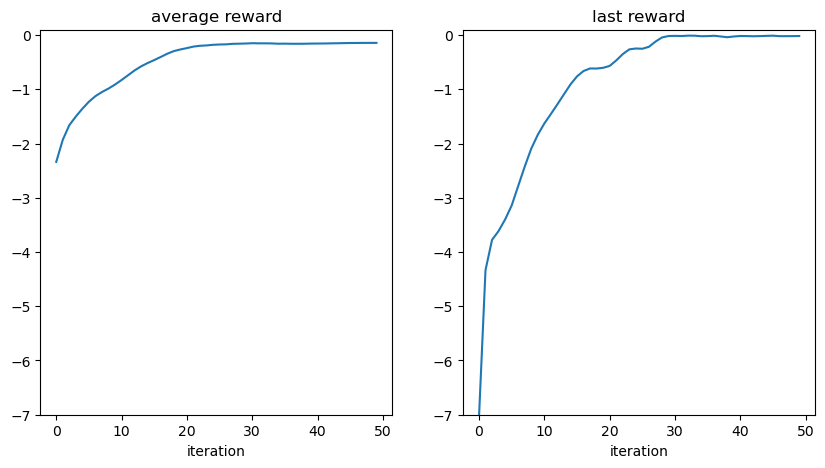

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.ylim(-7, 0.1)
plt.plot(logs["return"])
plt.title("average reward")
plt.xlabel("iteration")
plt.subplot(1, 2, 2)
plt.ylim(-7, 0.1)
plt.plot(logs["last_reward"])
plt.title("last reward")
plt.xlabel("iteration")
plt.savefig("training.png")

# Visualize the pulse produced by the trained network:

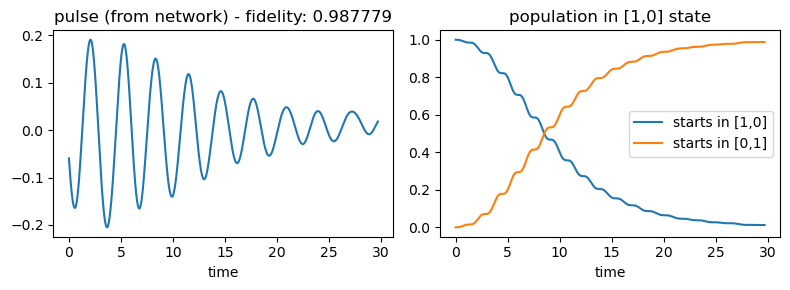

In [14]:

def get_control_pulse(net, params, timesteps=timesteps, dt=dt, ctype=torch.complex64):
    net.eval()
    psi = params["params"]["psi_0"][0]
    t_left = torch.tensor(1, device=device)
    t_increment = params["params"]["dt"][0]/params["params"]["gate_time"][0]
    H0_tensor = params["params"]["H0"][0]
    H1_tensor = params["params"]["H1"][0]
    psi_f = params["params"]["psi_f"][0]
    cntrl_seq = torch.zeros(timesteps, dtype=ctype, device=device)
    fid = torch.zeros(timesteps, device=device)
    psi_list = []
    for i in range(timesteps):
        cntrl = net(torch.real(psi).reshape((1,4,1)), torch.imag(psi).reshape((1,4,1)), t_left)
        cntrl_seq[i] = cntrl
        U = torch.linalg.matrix_exp(-1.0j*dt*(H0_tensor+cntrl*H1_tensor))
        psi = U@psi
        fid[i] = env.avg_fidelity(psi_f, psi)
        psi_list.append(psi.cpu().detach().numpy())
        t_left = t_left - t_increment

    return cntrl_seq.cpu().detach().numpy(), psi_list, fid.cpu().detach().numpy()

pulse, psi_list, fid = get_control_pulse(agent, params, timesteps=len_pulse)


prob0_start0 = [np.abs(s[0,0])**2 for s in psi_list]
prob0_start1 = [np.abs(s[0,1])**2 for s in psi_list]

f, ax = plt.subplots(ncols=2)
f.set_size_inches((8, 3))
ax[0].set_title(f"pulse (from network) - fidelity: {str(np.round(fid[-1], 6))}")
ax[1].set_title("population in [1,0] state")
ax[0].plot(tlist[:len_pulse], pulse)
ax[0].set_xlabel("time")
ax[1].plot(tlist[:len_pulse], prob0_start0, label="starts in [1,0]")
ax[1].plot(tlist[:len_pulse], prob0_start1, label="starts in [0,1]")
ax[1].set_xlabel("time")
ax[1].legend()
plt.tight_layout()
plt.savefig("pulse.png")
